## loading

In [9]:
import numpy as np
import os
# import matplotlib.pyplot as plt
from scipy.io import loadmat
from src.run_gsort_v2_wuericmod import *
import src.utilities.electrode_map as emap
from src.eierflib import smart_fit, sigmoid
import src.post_processing_utils as gpa
import pandas as pd
import tqdm
from scipy.stats import kde

# from run_gsort_v2_wuericmod import *
# import gsort_post_analysis as gpa

In [2]:
#load prior EI-ERF data
eiErfData = {}
for dataName,cellType in zip(['/Volumes/Lab/Users/Sasi/pystim/scripts/ei_erf_analysis/ei_erf_final_push_june20/dfMParasols.p',
                              '/Volumes/Lab/Users/Sasi/pystim/scripts/ei_erf_analysis/ei_erf_final_push_june20/dfMMidgets.p'],['parasols','midgets']):
    with open(dataName,'rb') as f:
        eiErfData[cellType] = pickle.load(f) #all data are below bundle threshold
    if cellType == 'midgets':
        #rename gsort thresholds as 'threshold' (only autosort thresholds were carefully vetted for parasols)
        for compt in ['soma','axon']: eiErfData[cellType][compt]['threshold'] = eiErfData[cellType][compt]['threshold_gsort']

In [3]:
#params
eierfParamsV = {'parasols-soma':(22*3.6+20,.4,30*3.6*.75),'parasols-axon':(6.5*3.6,.4,10*3.6*1.1),
                'midgets-soma':(22*3.6+15,.3*.76,7),'midgets-axon':(6.5*3.6,.28,3*3)}
DAC2V = 3.6
xRange = {'parasols-soma': (eierfParamsV['parasols-soma'][2],150*3), 'parasols-axon': (eierfParamsV['parasols-axon'][2],30*3),
          'midgets-soma': (eierfParamsV['midgets-soma'][2],150*3), 'midgets-axon': (eierfParamsV['midgets-axon'][2],30*3)}

numElecs = 512
#numElecs = 519
badElecInds = np.array([1,130,259,260,389,390,519]) - 1 if numElecs==519 else np.array([])
eiThr = -7
amps0 = np.array([0.10053543, 0.11310236, 0.11938583, 0.13195276, 0.14451969,
                   0.16337008, 0.17593701, 0.1947874 , 0.2136378 , 0.23877165,
                   0.25762205, 0.2780315 , 0.30330709, 0.35385827, 0.37913386,
                   0.42968504, 0.45496063, 0.50551181, 0.55606299, 0.60661417,
                   0.68244094, 0.73299213, 0.8088189 , 0.88464567, 0.98574803,
                   1.10433071, 1.20472441, 1.30511811, 1.40551181, 1.60629921,
                   1.70669291, 1.90748031, 2.10826772, 2.30905512, 2.50984252,
                   2.81102362, 3.11220472, 3.41338583, 3.71456693])

#funcs
def sigmoid(x,slope,thr):
    return 1/(1+np.exp(-slope*(x-thr)))

def eiErfCurve(x,a,b,c):
    return a/(x-c) + b

cellTypes = ['on parasol', 'on midget', 'off parasol', 'off midget']


## read-->plot new gsort

In [41]:
#read gsort
##define path JEFF CHANGE HERE----------------------------------------
gsortDir = '/Volumes/Scratch/Users/jeffbrown/short-window-consensus5/'
pieces = [w + '/' for w in os.listdir(gsortDir)]
stimpaths = [os.listdir(os.path.join(gsortDir, p))[0] for p in pieces]
eipath_first = [os.listdir(os.path.join(gsortDir, p, s))[0] for p, s in zip(pieces, stimpaths)]
eipath_second = [os.listdir(os.path.join(gsortDir, p, s, e1))[0] for p, s, e1 in zip(pieces, stimpaths, eipath_first)]
eipaths = [ os.path.join(e1,e2) if os.path.isdir(os.path.join(gsortDir, p, s, e1, e2)) else e1 for p, s, e1, e2 in zip(pieces, stimpaths, eipath_first, eipath_second)]
eipathGSs = eipaths


# pieces = ['2015-04-09-2/', '2016-02-17-5/', '2016-06-13-0/', '2016-06-13-8/', '2016-06-13-9/', '2017-11-20-9/', '2018-03-01-1/',  '2020-01-30-1/', '2020-10-06-7/', '2019-06-20-0/', '2020-09-12-4/', '2020-10-18-5/', '2019-11-07-2/', '2020-10-06-5/', '2021-05-27-0/']
# regions = ['periphery']*6 + ['central']*9
# eipathGSs = ['data001', 'data003', 'kilosort_data000/data000','kilosort_data000/data000', 'kilosort_data000/data000', 'kilosort_data000/data000', 'kilosort_data000/data000', 'kilosort_data000/data000', 'kilosort_data000/data000', 'kilosort_data000/data000', 'kilosort_data000/data000', 'kilosort_data002/data002', 'kilosort_data000/data000', 'kilosort_data000/data000', 'data001']
# ; 
# eipaths = ['data001', 'data003', 'kilosort_data000/data000','kilosort_data000/data000', 'kilosort_data000/data000', 'kilosort_data000/data000', 'kilosort_data000/data000', 'kilosort_data000/data000', 'kilosort_data000/data000', 'kilosort_data000/data000', 'kilosort_data000/data000', 'kilosort_data002/data002', 'kilosort_data000/data000', 'kilosort_data000/data000', 'data001']
# stimpaths = ['data002', 'data001-data002-new', 'data001', 'data001', 'data001', 'data002', 'data001', 'data001', 'data001', 'data001', 'data001', 'data001', 'data001', 'data001', 'data002']

elecData = {}
for key in ['piece', 'ei_dataset', 'stim_dataset', 'elecInd', 'cell', 'eiVal', 'celltype', 'compartment',
                'threshold_gsort', 'slope_gsort', 'amps_gsort', 'probs_gsort', 'threshold_gsort_plus', 
                'slope_gsort_plus', 'probs_gsort_plus', 'region']:
        elecData[key] = []


for piece, eipathGS, eipath, stimpath, region in zip(pieces, eipathGSs, eipaths, stimpaths, regions):
    print('piece',piece)
    outpath = os.path.join(gsortDir, piece, stimpath, eipathGS)
    parameters = loadmat(os.path.join(outpath, 'parameters.mat'))

    cells = parameters['cells'].flatten()
    sorted_cells = parameters['gsorted_cells'].flatten()
    num_cells = len(cells)
    num_patterns = max(parameters['patterns'].flatten())
    num_movies = parameters['movies'].flatten()[0]

    all_probs = np.memmap(os.path.join(outpath, 'init_probs.dat'),mode='r',shape=(num_cells, num_patterns, num_movies), dtype='float32')
    all_probs_plus = np.memmap(os.path.join(outpath, 'final_probs.dat'),mode='r',shape=(num_cells, num_patterns, num_movies), dtype='float32')
    
    ##JEFF CHANGE HERE------------------------------------------------------------

    vision_data = vl.load_vision_data(os.path.join('/Volumes/Analysis/',piece,eipathGS),
                                        eipath.split('/')[-1],
                                        include_params=True,
                                        include_ei=True,
                                        include_sta=False,
                                        include_neurons=True)
    cell_id_list = vision_data.get_cell_ids(); numCells = len(cell_id_list)

    ##intialize data collection
    


    ##go through cells
    for cc,cell_id in enumerate(cell_id_list):
        eiFull = vision_data.get_ei_for_cell(cell_id).ei
        ei = np.min(eiFull, axis =1) #'min' because EIs are negative
        celltype = vision_data.get_class_for_cell(cell_id).lower()
        # print(celltype)
        if celltype not in [i.lower() for i in cellTypes]: celltype = 'other' #later addition
        # print(celltype)
        for pInd in range(numElecs):
            if ei[pInd] > eiThr or pInd in badElecInds: continue #ei threshold

            gsortIdx = np.where(cells==cell_id)[0]
            if gsortIdx in sorted_cells and gsortIdx.size > 0 and np.any(all_probs[gsortIdx,pInd,:].flatten()):
                probs = all_probs[gsortIdx,pInd,:].flatten()
                probs[np.isnan(probs)] = 0
                probs[:12]=0
                fprobs = all_probs_plus[gsortIdx,pInd,:].flatten()
                fprobs[np.isnan(fprobs)] = 0
                fprobs[:12]=0
                
                threshold,slope,amps,probs = smart_fit(amps0,probs)
                fthreshold,fslope,amps,fprobs = smart_fit(amps0,fprobs)

                
                elecData['piece'].append(piece)
                elecData['ei_dataset'].append(stimpath)
                elecData['stim_dataset'].append(eipath)
                elecData['elecInd'].append(pInd)
                elecData['cell'].append(cell_id)
                elecData['eiVal'].append(ei[pInd])
                if len(celltype.split(" ")) > 1:
                    elecData['celltype'].append(celltype.split(" ")[1])
                else:
                    elecData['celltype'].append(celltype)
                elecData['compartment'].append(eil.axonorsomaRatio(eiFull[pInd,:]))
                elecData['threshold_gsort'].append(threshold)
                elecData['slope_gsort'].append(slope)
                elecData['amps_gsort'].append(amps)
                elecData['probs_gsort'].append(probs)
                
                elecData['threshold_gsort_plus'].append(fthreshold)
                elecData['slope_gsort_plus'].append(fslope)
                elecData['probs_gsort_plus'].append(fprobs)
                
                elecData['region'].append(region)
    

gsortData = pd.DataFrame(elecData)


piece 2020-10-06-5/
piece 2017-11-20-9/
piece 2019-06-20-0/
piece 2016-06-13-8/
piece 2020-09-12-4/
piece 2020-10-18-0/
piece 2015-04-09-2/
piece 2021-05-27-4/
piece 2016-06-13-9/
piece 2020-01-30-1/
piece 2018-03-01-1/
piece 2020-09-29-2/
piece 2020-02-27-2/
piece 2016-06-13-0/
piece 2020-10-06-7/


In [42]:
gsortData.to_csv("/Volumes/Lab/Users/jeffbrown/g-sort/data/final_analysis.csv")

/tmp/ipykernel_35046/1669879481.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return a/(x-c) + b
/tmp/ipykernel_35046/2945909332.py:12: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  gsortDataFoo = gsortData[(gsortData['threshold_gsort'].between(0,5,inclusive=False)) &\
/tmp/ipykernel_35046/2945909332.py:18: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  gsortDataFoo = gsortData[(gsortData['threshold_gsort_plus'].between(0,5,inclusive=False)) &\


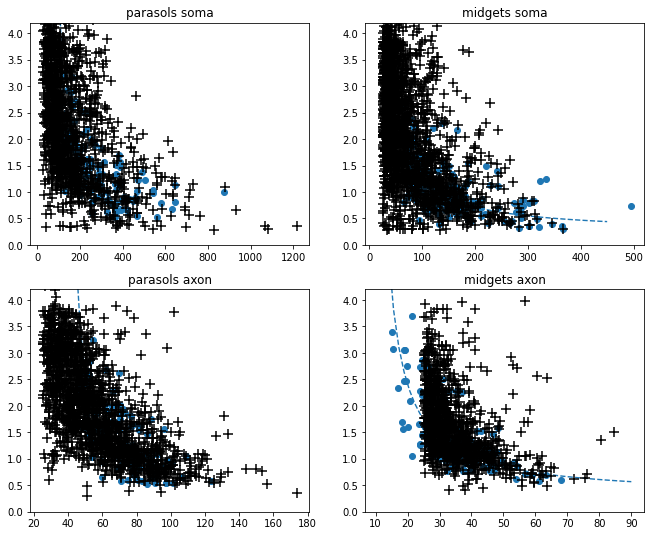

In [7]:
fig,ax = plt.subplots(2,2,figsize=(11,9))
for tt,ct in enumerate(['parasols','midgets']) :
    for cc,compt in enumerate(['soma','axon']) :
        
        ax[cc,tt].scatter(np.abs(eiErfData[ct][compt]['eiVal'])*DAC2V, eiErfData[ct][compt]['threshold'])
        ax[cc,tt].plot(np.linspace(*xRange[ct+'-'+compt]), eiErfCurve(np.linspace(*xRange[ct+'-'+compt]),*eierfParamsV[ct+'-'+compt]),linestyle='dashed',lw=1.4)
        ax[cc,tt].set_title(ct+' '+compt)
        ax[cc,tt].set_ylim([0,4.2])
        
        #GSORT TO INSPECT--------------------------------------------------
        if compt == 'soma':
            gsortDataFoo = gsortData[(gsortData['threshold_gsort'].between(0,5,inclusive=False)) &\
                                     (gsortData['compartment']==compt) &\
                                     (ct[:-1] == gsortData['celltype']) &\
                                     (gsortData['region']=='periphery')]
            ax[cc,tt].scatter(np.abs(gsortDataFoo['eiVal'])*DAC2V, gsortDataFoo['threshold_gsort'], marker='+',s=90,zorder=2, c='k')
        elif compt == 'axon':
            gsortDataFoo = gsortData[(gsortData['threshold_gsort_plus'].between(0,5,inclusive=False)) &\
                                     (gsortData['compartment']==compt) &\
                                     (ct[:-1] == gsortData['celltype']) &\
                                     (gsortData['region']=='periphery')]
            ax[cc,tt].scatter(np.abs(gsortDataFoo['eiVal'])*DAC2V, gsortDataFoo['threshold_gsort_plus'], marker='+',s=90,zorder=2, c='k')
        
plt.show()

/tmp/ipykernel_35046/1669879481.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return a/(x-c) + b
/tmp/ipykernel_35046/2115150232.py:12: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  gsortDataFoo = gsortData[(gsortData['threshold_gsort'].between(0,5,inclusive=False)) &\
/tmp/ipykernel_35046/2115150232.py:27: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  gsortDataFoo = gsortData[(gsortData['threshold_gsort_plus'].between(0,5,inclusive=False)) &\


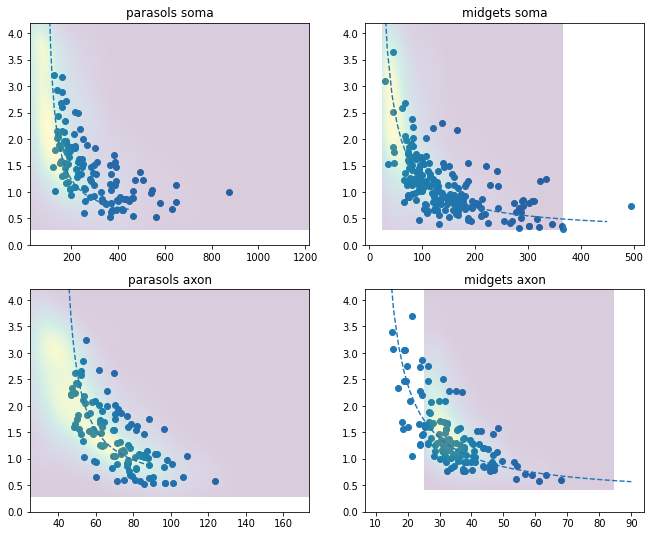

In [10]:
fig,ax = plt.subplots(2,2,figsize=(11,9))
for tt,ct in enumerate(['parasols','midgets']) :
    for cc,compt in enumerate(['soma','axon']) :
        
        ax[cc,tt].scatter(np.abs(eiErfData[ct][compt]['eiVal'])*DAC2V, eiErfData[ct][compt]['threshold'])
        ax[cc,tt].plot(np.linspace(*xRange[ct+'-'+compt]), eiErfCurve(np.linspace(*xRange[ct+'-'+compt]),*eierfParamsV[ct+'-'+compt]),linestyle='dashed',lw=1.4)
        ax[cc,tt].set_title(ct+' '+compt)
        ax[cc,tt].set_ylim([0,4.2])
        
        #GSORT TO INSPECT--------------------------------------------------
        if compt == 'soma':
            gsortDataFoo = gsortData[(gsortData['threshold_gsort'].between(0,5,inclusive=False)) &\
                                     (gsortData['compartment']==compt) &\
                                     (ct[:-1] == gsortData['celltype']) &\
                                     (gsortData['region']=='periphery')]
            x = np.abs(gsortDataFoo['eiVal'])*DAC2V
            y = gsortDataFoo['threshold_gsort']
            k = kde.gaussian_kde([x,y])
            nbins=300
            xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
            zi = k(np.vstack([xi.flatten(), yi.flatten()]))

            # Make the plot
            ax[cc,tt].pcolormesh(xi, yi, zi.reshape(xi.shape), alpha = 0.2)

        elif compt == 'axon':
            gsortDataFoo = gsortData[(gsortData['threshold_gsort_plus'].between(0,5,inclusive=False)) &\
                                     (gsortData['compartment']==compt) &\
                                     (ct[:-1] == gsortData['celltype']) &\
                                     (gsortData['region']=='periphery')]
            x = np.abs(gsortDataFoo['eiVal'])*DAC2V
            y = gsortDataFoo['threshold_gsort_plus']
            k = kde.gaussian_kde([x,y])
            nbins=300
            xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
            zi = k(np.vstack([xi.flatten(), yi.flatten()]))

            # Make the plot
            ax[cc,tt].pcolormesh(xi, yi, zi.reshape(xi.shape), alpha = 0.2)

plt.show()

/tmp/ipykernel_35046/656351160.py:12: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  gsortDataFoo = gsortData[(gsortData['threshold_gsort'].between(0,5,inclusive=False)) &\
/tmp/ipykernel_35046/656351160.py:18: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  gsortDataFoo = gsortData[(gsortData['threshold_gsort_plus'].between(0,5,inclusive=False)) &\


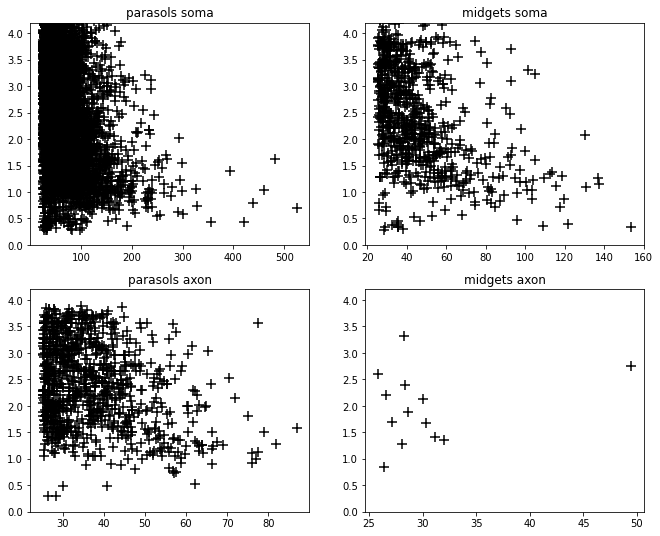

In [11]:
fig,ax = plt.subplots(2,2,figsize=(11,9))
for tt,ct in enumerate(['parasols','midgets']) :
    for cc,compt in enumerate(['soma','axon']) :
        
#         ax[cc,tt].scatter(np.abs(eiErfData[ct][compt]['eiVal'])*DAC2V, eiErfData[ct][compt]['threshold'])
#         ax[cc,tt].plot(np.linspace(*xRange[ct+'-'+compt]), eiErfCurve(np.linspace(*xRange[ct+'-'+compt]),*eierfParamsV[ct+'-'+compt]),linestyle='dashed',lw=1.4)
        ax[cc,tt].set_title(ct+' '+compt)
        ax[cc,tt].set_ylim([0,4.2])
        
        #GSORT TO INSPECT--------------------------------------------------
        if compt == 'soma':
            gsortDataFoo = gsortData[(gsortData['threshold_gsort'].between(0,5,inclusive=False)) &\
                                     (gsortData['compartment']==compt) &\
                                     (ct[:-1] == gsortData['celltype']) &\
                                     (gsortData['region']=='central')]
            ax[cc,tt].scatter(np.abs(gsortDataFoo['eiVal'])*DAC2V, gsortDataFoo['threshold_gsort'], marker='+',s=90,zorder=2, c='k')
        elif compt == 'axon':
            gsortDataFoo = gsortData[(gsortData['threshold_gsort_plus'].between(0,5,inclusive=False)) &\
                                     (gsortData['compartment']==compt) &\
                                     (ct[:-1] == gsortData['celltype']) &\
                                     (gsortData['region']=='central')]
            ax[cc,tt].scatter(np.abs(gsortDataFoo['eiVal'])*DAC2V, gsortDataFoo['threshold_gsort_plus'], marker='+',s=90,zorder=2, c='k')
        
plt.show()

/tmp/ipykernel_5692/1564672644.py:12: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  gsortDataFoo = gsortData[(gsortData['threshold_gsort'].between(0,5,inclusive=False)) &\
/tmp/ipykernel_5692/1564672644.py:27: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  gsortDataFoo = gsortData[(gsortData['threshold_gsort_plus'].between(0,5,inclusive=False)) &\


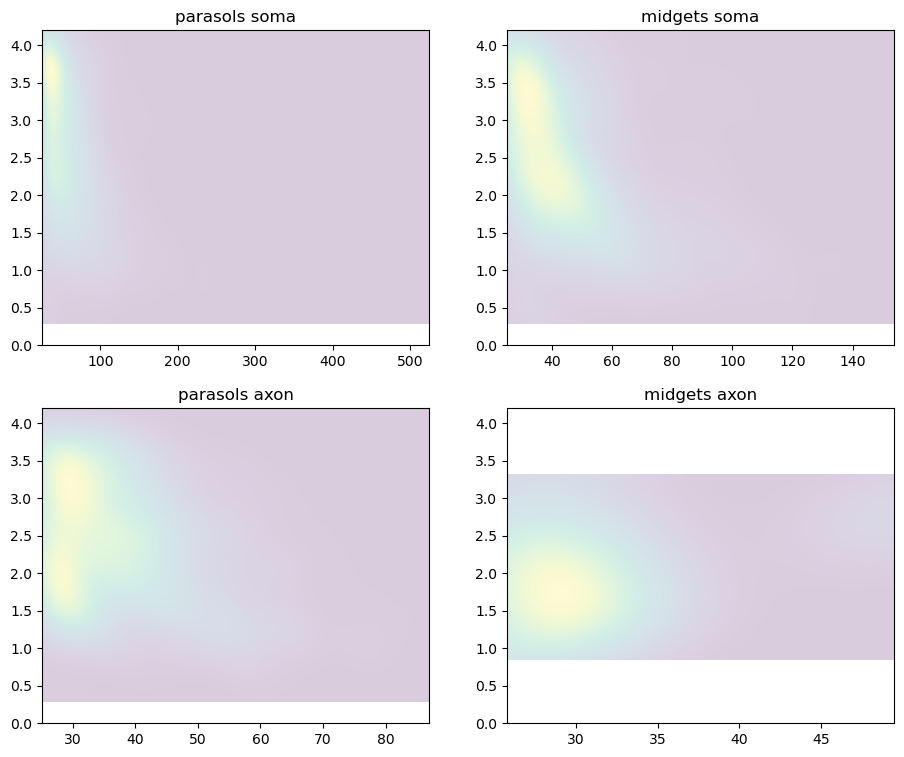

In [68]:
fig,ax = plt.subplots(2,2,figsize=(11,9))
for tt,ct in enumerate(['parasols','midgets']) :
    for cc,compt in enumerate(['soma','axon']) :
        
#         ax[cc,tt].scatter(np.abs(eiErfData[ct][compt]['eiVal'])*DAC2V, eiErfData[ct][compt]['threshold'])
#         ax[cc,tt].plot(np.linspace(*xRange[ct+'-'+compt]), eiErfCurve(np.linspace(*xRange[ct+'-'+compt]),*eierfParamsV[ct+'-'+compt]),linestyle='dashed',lw=1.4)
        ax[cc,tt].set_title(ct+' '+compt)
        ax[cc,tt].set_ylim([0,4.2])
        
        #GSORT TO INSPECT--------------------------------------------------
        if compt == 'soma':
            gsortDataFoo = gsortData[(gsortData['threshold_gsort'].between(0,5,inclusive=False)) &\
                                     (gsortData['compartment']==compt) &\
                                     (ct[:-1] == gsortData['celltype']) &\
                                     (gsortData['region']=='central')]
            x = np.abs(gsortDataFoo['eiVal'])*DAC2V
            y = gsortDataFoo['threshold_gsort']
            k = kde.gaussian_kde([x,y])
            nbins=300
            xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
            zi = k(np.vstack([xi.flatten(), yi.flatten()]))

            # Make the plot
            ax[cc,tt].pcolormesh(xi, yi, zi.reshape(xi.shape), alpha = 0.2)
            
        elif compt == 'axon':
            gsortDataFoo = gsortData[(gsortData['threshold_gsort_plus'].between(0,5,inclusive=False)) &\
                                     (gsortData['compartment']==compt) &\
                                     (ct[:-1] == gsortData['celltype']) &\
                                     (gsortData['region']=='central')]
            x = np.abs(gsortDataFoo['eiVal'])*DAC2V
            y = gsortDataFoo['threshold_gsort_plus']
            k = kde.gaussian_kde([x,y])
            nbins=300
            xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
            zi = k(np.vstack([xi.flatten(), yi.flatten()]))

            # Make the plot
            ax[cc,tt].pcolormesh(xi, yi, zi.reshape(xi.shape), alpha = 0.2)
#         ax[cc,tt].set_xlim([0,150])
plt.show()

/tmp/ipykernel_17827/1318496235.py:13: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  gsortDataFoo = gsortData[(gsortData['threshold_gsort'].between(0,5,inclusive=False)) &\
/tmp/ipykernel_17827/1318496235.py:13: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  gsortDataFoo = gsortData[(gsortData['threshold_gsort'].between(0,5,inclusive=False)) &\
/tmp/ipykernel_17827/1318496235.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


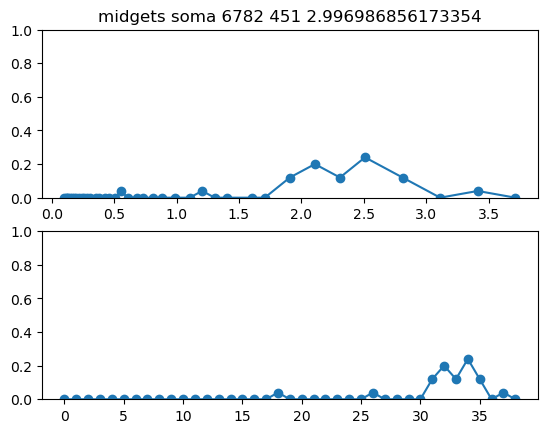

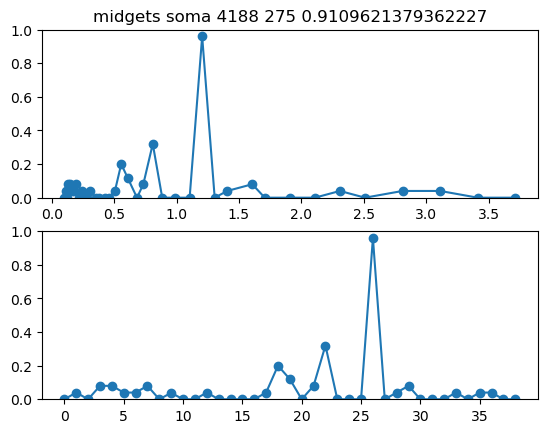

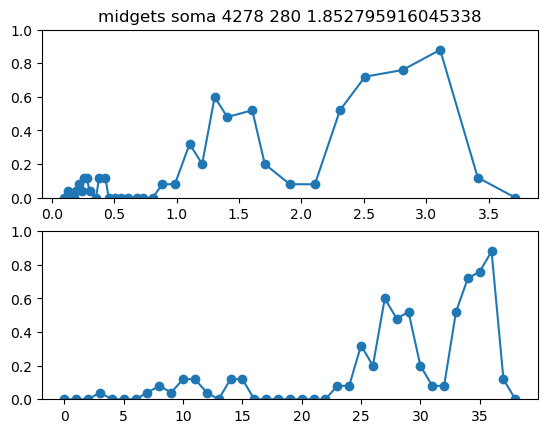

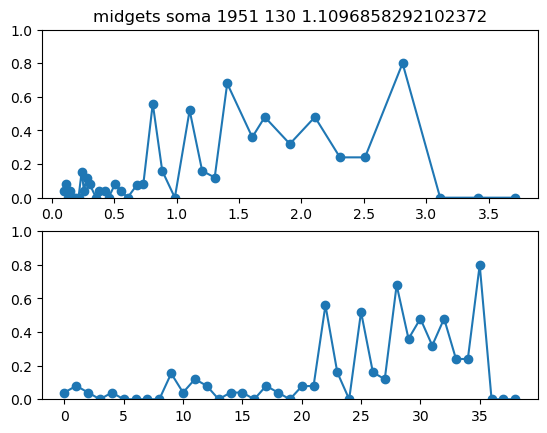

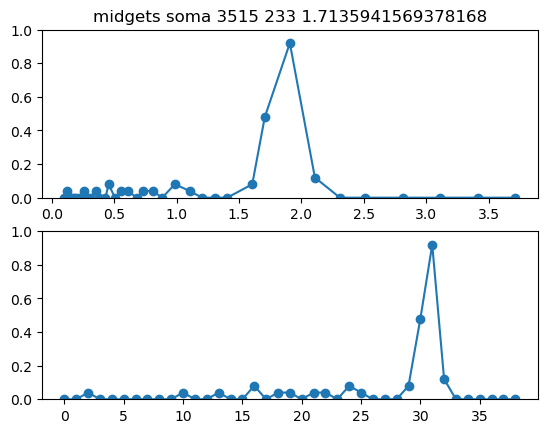

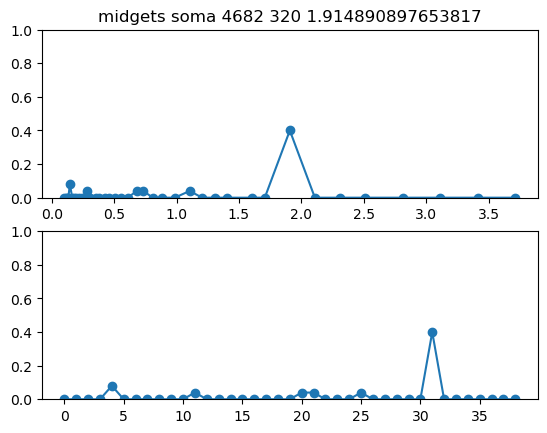

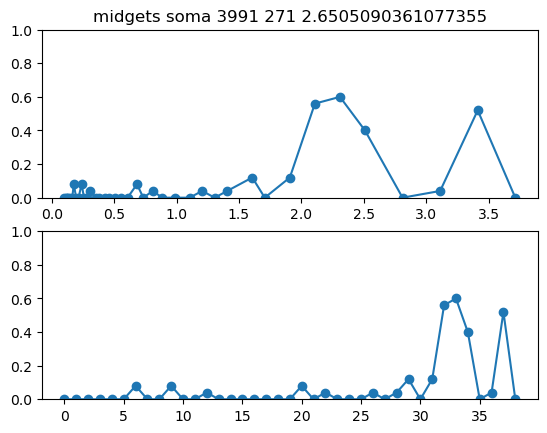

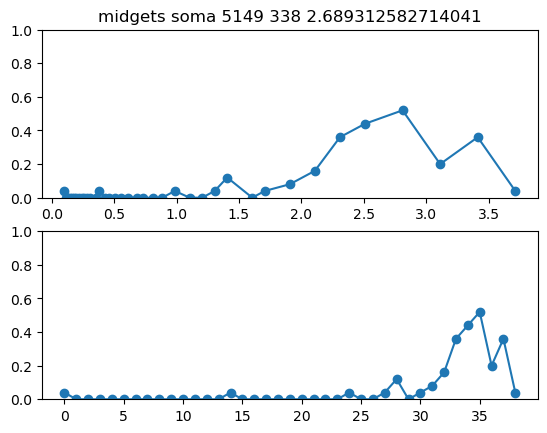

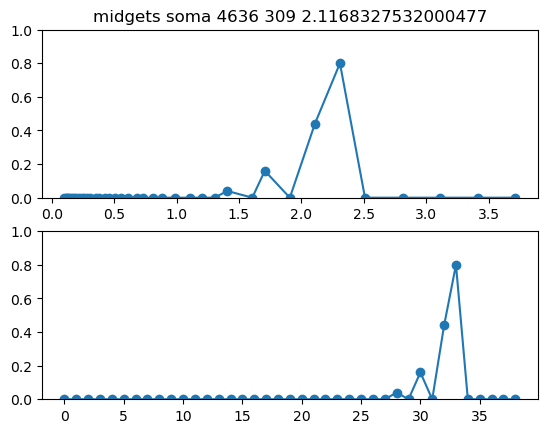

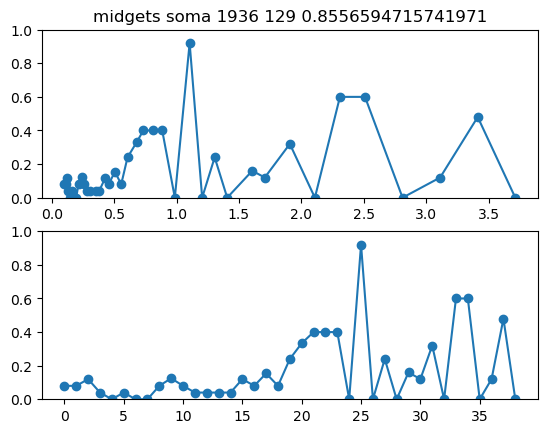

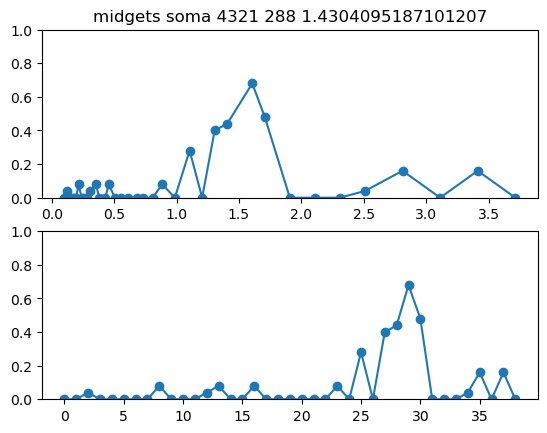

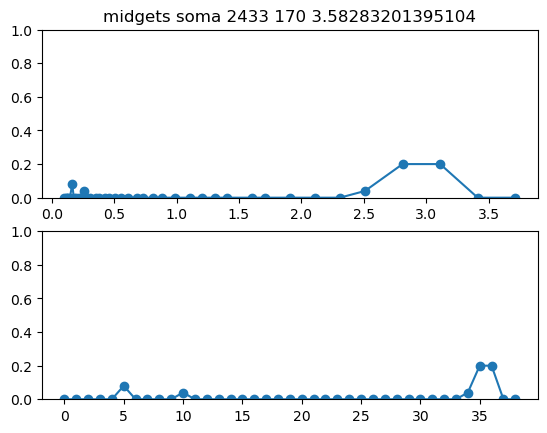

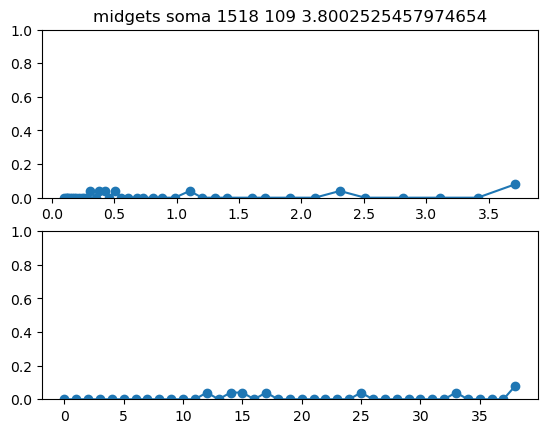

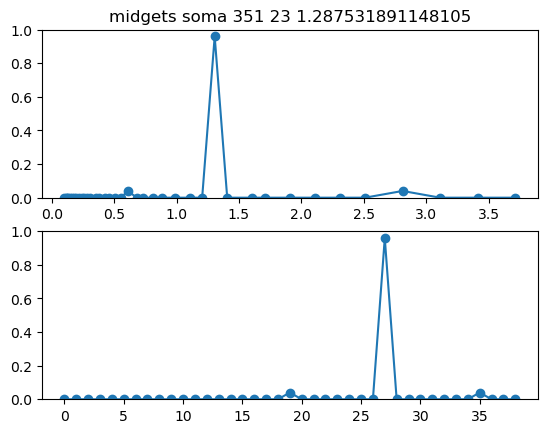

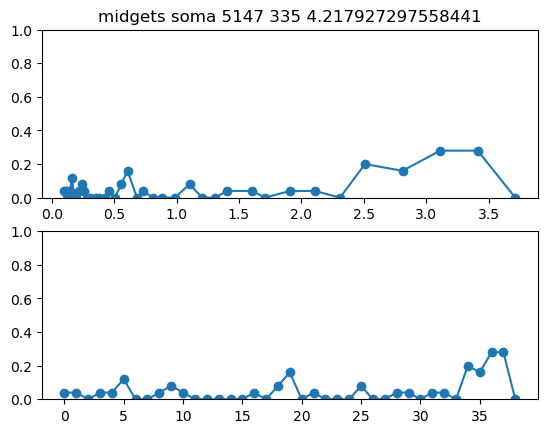

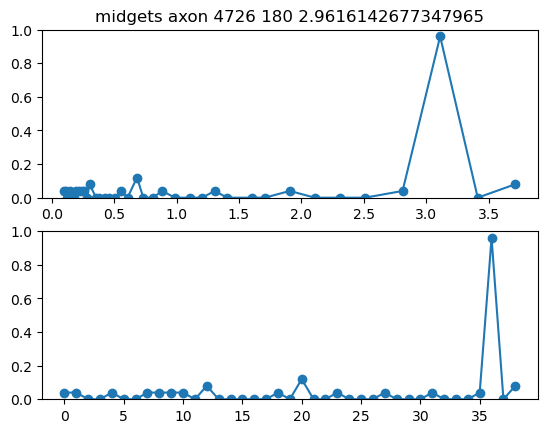

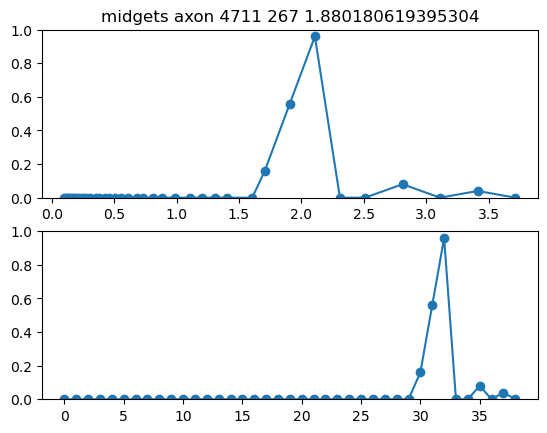

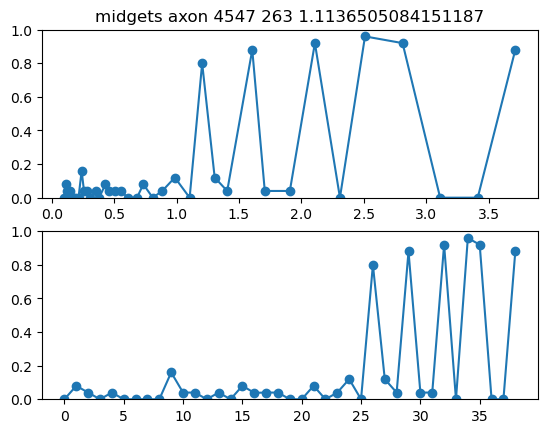

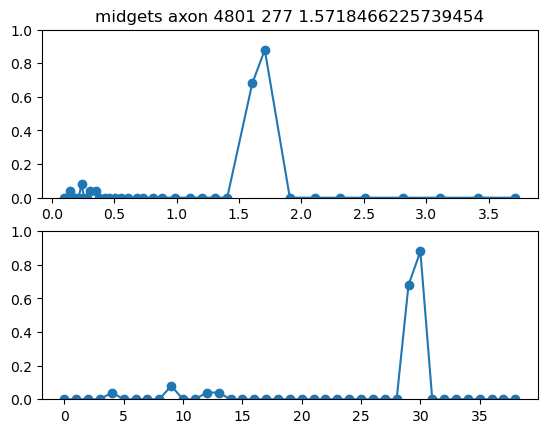

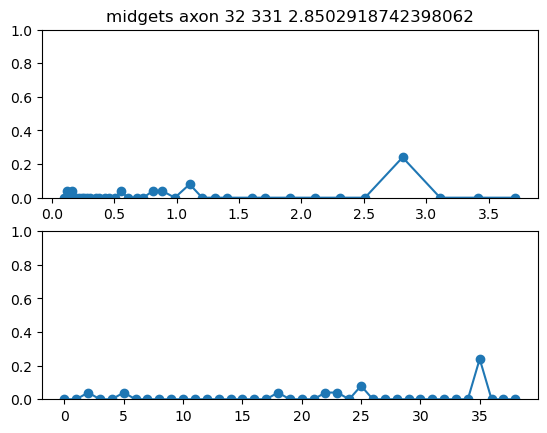

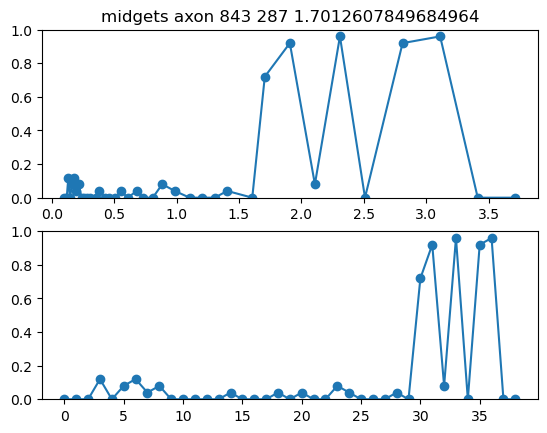

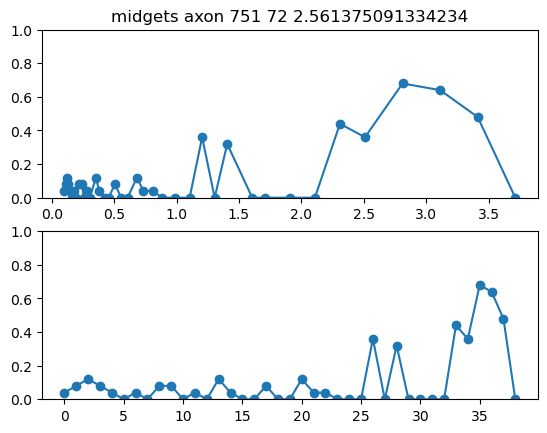

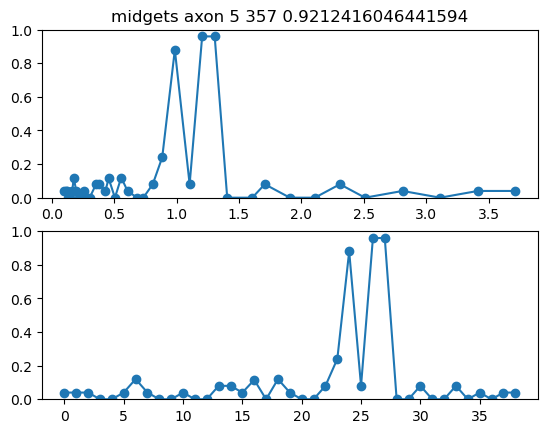

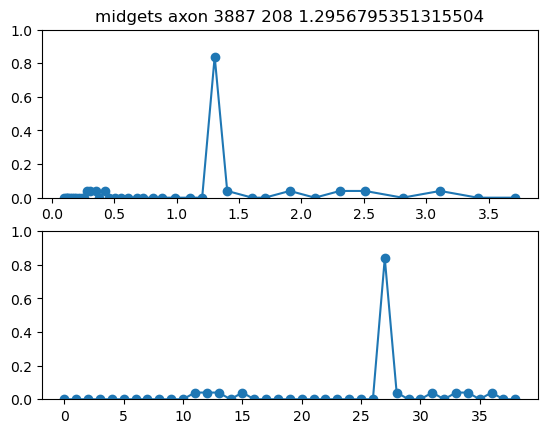

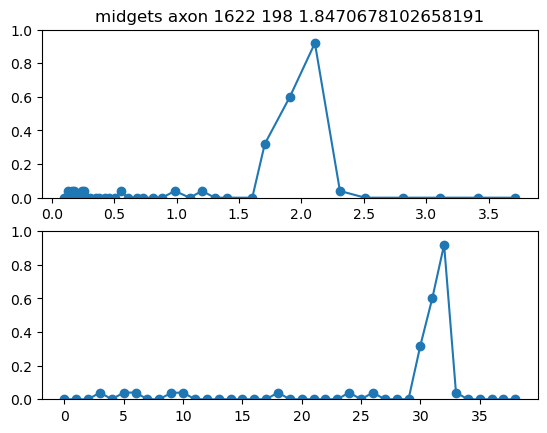

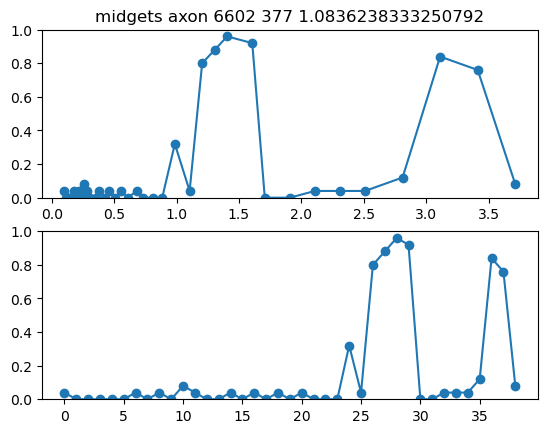

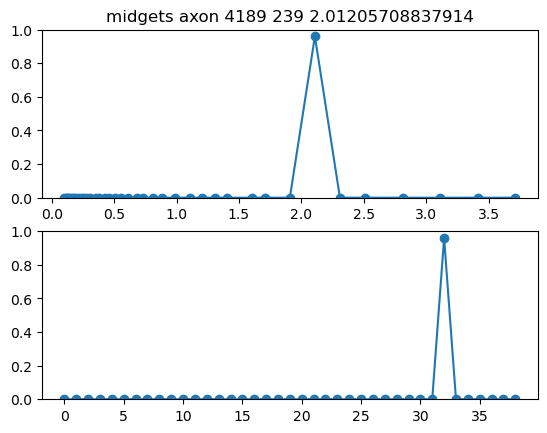

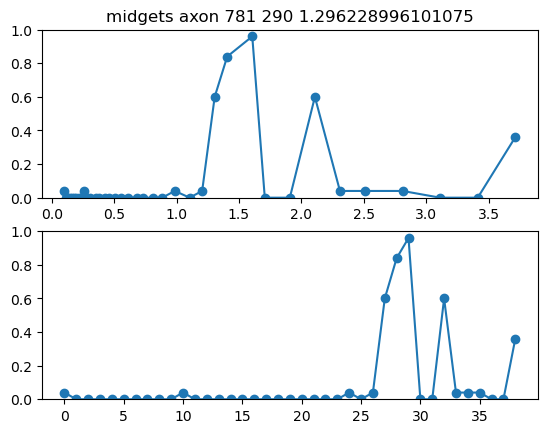

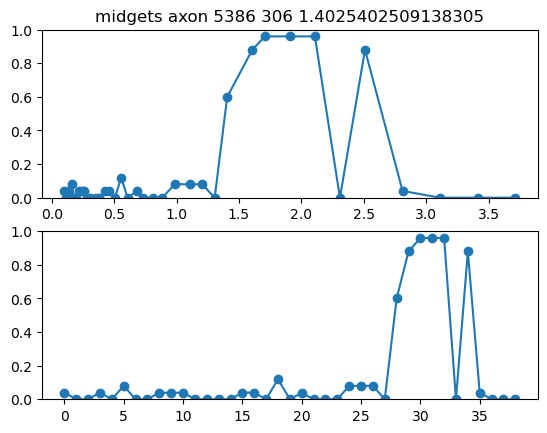

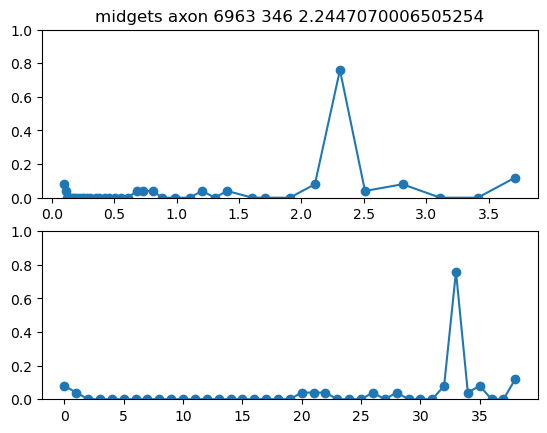

In [9]:
for tt,ct in enumerate(['midgets']) :
    for cc,compt in enumerate(['soma','axon']) :
        # ax[cc,tt].scatter(np.abs(eiErfData[ct][compt]['eiVal'])*DAC2V, eiErfData[ct][compt]['threshold'])
        # ax[cc,tt].plot(np.linspace(*xRange[ct+'-'+compt]), eiErfCurve(np.linspace(*xRange[ct+'-'+compt]),*eierfParamsV[ct+'-'+compt]),linestyle='dashed',lw=1.4)
        # ax[cc,tt].set_title(ct+' '+compt)
        # ax[cc,tt].set_ylim([0,4.2])
        
        #GSORT TO INSPECT--------------------------------------------------
        # gsortDataFoo = gsortData[(gsortData['threshold_gsort'].between(0,5,inclusive=False)) &\
        #                          (gsortData['compartment']==compt) &\
        #                          (ct[:-1] == gsortData['celltype'])]
        # ax[cc,tt].scatter(np.abs(gsortDataFoo['eiVal'])*DAC2V, gsortDataFoo['threshold_gsort'], marker='+',s=90,zorder=2, c='k')
        gsortDataFoo = gsortData[(gsortData['threshold_gsort'].between(0,5,inclusive=False)) &\
                                 (gsortData['compartment']==compt) &\
                                 (ct[:-1] == gsortData['celltype'])]
        selected_probs = gsortDataFoo['probs_gsort']
        selected_amps= gsortDataFoo['amps_gsort']
        selected_cells = gsortDataFoo['cell']
        selected_patterns = gsortDataFoo['elecInd']
        selected_thresholds = gsortDataFoo['threshold_gsort']
        
        
        # for j in np.where((np.abs(gsortDataFoo['eiVal'])*DAC2V > 100) * (gsortDataFoo['threshold_gsort'] < 1))[0][:15]:
        for j in random.sample(list(np.arange(len(selected_probs))), 15):
            plt.figure()
            ax = plt.subplot(211)
            ax.plot(selected_amps.iloc[j], selected_probs.iloc[j], "-o")
            ax.set_title(f"{ct} {compt} {selected_cells.iloc[j]} {selected_patterns.iloc[j]} {selected_thresholds.iloc[j]}")
            ax.set_ylim([0,1])

            ax2 = plt.subplot(212)
            ax2.plot( selected_probs.iloc[j], "-o")
            # ax2.set_title(f"{ct} {compt} {selected_cells.iloc[j]} {selected_patterns.iloc[j]}")
            ax2.set_ylim([0,1])
plt.show()